In [1]:
# Refer to https://github.com/karlwx/GOES16python/blob/master/Visualizing%20GOES-16%20ABI%20Data%20With%20Python.ipynb

# Import libraries needed
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pyproj import Proj

# Plot output within notebook
%matplotlib inline

In [2]:
def rebin_ndarray(ndarray, new_shape, operation='avg'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.

    Number of output dimensions must match number of input dimensions.

    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = rebin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)

    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]

    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d, c in zip(new_shape,
                                                   ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1*(i+1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1*(i+1))
    return ndarray


In [3]:
# Takes in RGB triples where values of R, G and B range from 0 to 255.
# For each RGB triple there is a corresponding position on the colorbar.
# This function will nterpolate the colors in between the values you choose.
# You must first know the intended range of your colorbar.

# Sample inputs for popular colormap used by NWS
# colors = [(255,255,255), (255,255,0), (140,25,115), (255,125,200),(255,255,255), (0,0,0), \
#           (255,0,0), (255,255,0), (0,255,0), (0,0,115), (0,255,255), (200,200,200), (0,0,0)]
# position = [0, .12, .120001, .18, .180001, .25, .29, .35, .41, .49, .55, .550001, 1]
# my_cmap = make_cmap(colors, position=position, bit=True)

def make_cmap(colors, position=None, bit=False):
    
    import matplotlib as mpl
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

In [4]:
# Read netcdf file
# MAKE SURE TO USE THE BAND 2 FILE, NOT THE MULTI-BAND FILE 
C_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/FD/Ch02/OR_ABI-L2-CMIPF-M6C02_G16_s20191001500211_e20191001509519_c20191001509592.nc'
C = Dataset(C_file, 'r')

# Get date and time
add_seconds = C.variables['t'][0] # Number of seconds since year 2000
add_seconds=int(add_seconds)
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds) # This is now formatted as a python datetime message

In [5]:
# Read in the data
# For this band, the data are albedoes, ranging from 0 to 1.
# FD: (21696, 21696)   CONUS: (6000, 10000)
R = C.variables['CMI'][:]

# Make sure all values are between 0 and 1
R=np.clip(R, 0, 1)

# Optional: Apply a gamma correction to increase or decrease contrast between land and clouds.
# Gamma less than one will increase contrast
gamma = 0.4 # Works well in this instance
R = np.power(R, gamma)

In [6]:
# Reduce size of R to area of interest [lons,lats] = [+160:-90,20:70]
R_size = np.shape(R)
print "R_size = ",R_size

R_size =  (21696, 21696)


In [ ]:
# Grab the variables we need
sat_h = C.variables['goes_imager_projection'].perspective_point_height
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin

# The projection x and y coordinates equals
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

# Project into Lambert Conformal Conic projection
# Satellite sweep
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

# using the Proj library to generate map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

print "lons_shape = ",np.shape(lons)
print "lats_shape = ",np.shape(lats)

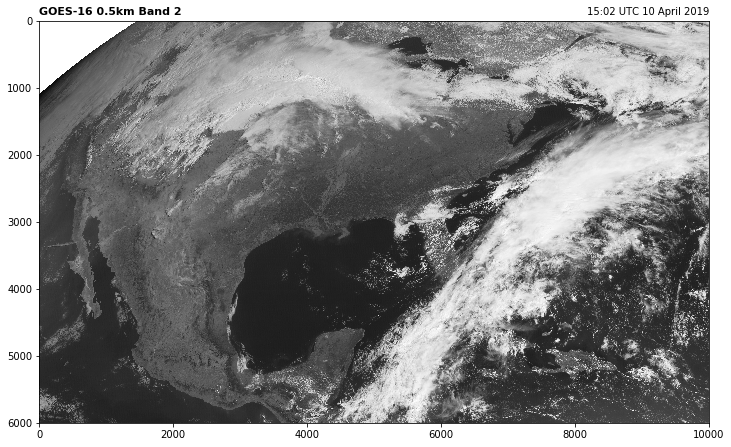

In [7]:
# Plot the image with a standard colorbar
plt.figure(figsize=[12, 9.5])  # for CONUS
#plt.figure(figsize=[12, 12])   # for FD
plt.imshow(R, cmap='Greys_r') # Reverse to have clouds show up as white
plt.title('GOES-16 0.5km Band 2', loc='left', fontweight='semibold', fontsize=11)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right', fontsize=10) # Stating the date/time of image
plt.show()

/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


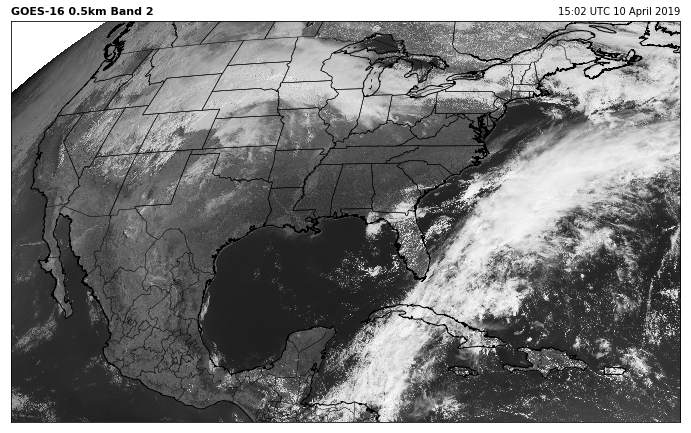

In [8]:
# Add a basemap
# Grab the variables we need
sat_h = C.variables['goes_imager_projection'].perspective_point_height
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin

# The projection x and y coordinates equals
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

# The basemap
m = Basemap(projection='geos', lon_0=sat_lon,
            resolution='i', area_thresh=5000,
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())

plt.figure(figsize=[12, 9.5])
m.imshow(np.flipud(R), cmap='Greys_r') # Need to flip up/down because images are upside-down in basemap
m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('GOES-16 0.5km Band 2', loc='left', fontweight='semibold', fontsize=11)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right', fontsize=10)
plt.show()


/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


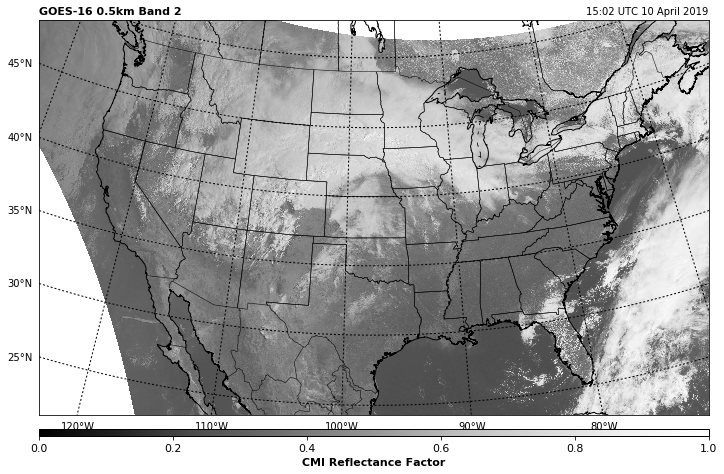

In [9]:
# Project into Lambert Conformal Conic projection
# Satellite sweep
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

# using the Proj library to generate map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

# Important: Set the "Outer Space" pixels to a point in the Gulf of Alaska
# Without this, re-projections will appear distorted 
lats[R.mask] = 57
lons[R.mask] = -152

# Make a new map object for CONUS Lambert Conformal Conic Projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

# Plot the image
plt.figure(figsize=[12, 9.5])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, R, cmap='Greys_r', linewidth=0, latlon=True)
mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()
# Optional: draw some parallels and meridians: labels = [left,right,top,bottom]
parallels = np.arange(0.,81,5.)
mH.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(10.,351.,10.)
mH.drawmeridians(meridians,labels=[False,False,False,True])

# Draw a colorbar
plt.clim(0,1) #IMPORTANT: SET COLORMAP LIMITS
cb = mH.colorbar(location='bottom')
# Make the colorbar more appealing
cb.ax.set_aspect(.01) # Make it skinnier than the default
cb.outline.set_linewidth(1) # Set border width to match plot
cb.ax.set_xticklabels(cb.ax.get_xticklabels(), fontsize=11) # Tick label size
cb.set_label(label='CMI Reflectance Factor',weight='bold',fontsize=11) # Colorbar title size

plt.title('GOES-16 0.5km Band 2', fontweight='semibold', fontsize=11, loc='left')
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right', fontsize='10')
plt.show()

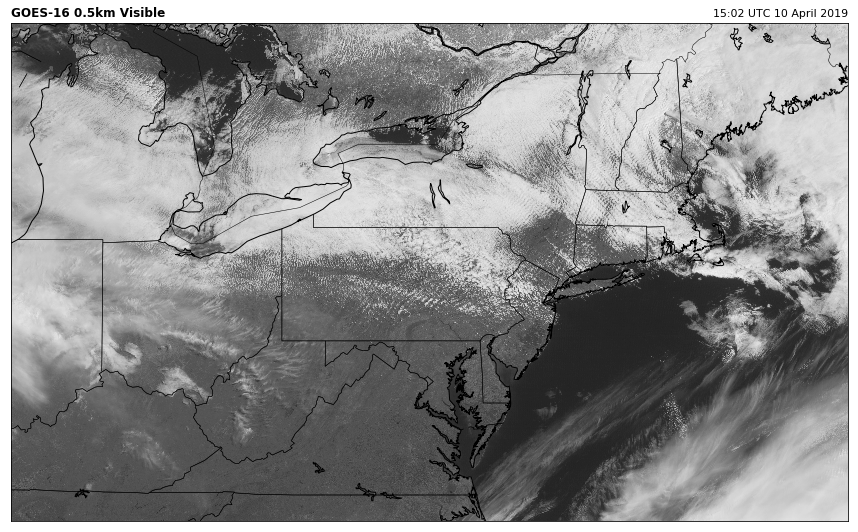

In [10]:
# View a subregion (the mid-Atlantic)
# Because of the high resolution of this file, the image does not have a blocky or pixelated appearance
# The downside of this is that it does take quite a bit of time to generate the plot
# Images can be generatd much faster by using the 2.0km resolution (see next step)

mZ = Basemap(projection='mill', llcrnrlon=-87, \
    urcrnrlon=-67, llcrnrlat=36, \
    urcrnrlat=46, resolution='i')
#mZ = Basemap(projection='mill', llcrnrlon=160, \
#    urcrnrlon=-90, llcrnrlat=20, \
#    urcrnrlat=70, resolution='i')

lon, lat = mZ(lons, lats) # Convert lat and lon to map coordinates, because this projection seems to require that

plt.figure(figsize=[15,12])
#plt.figure(figsize=[12,12])
mZ.pcolormesh(lon, lat, R, cmap='Greys_r', linewidth=0) # Can't use latlon = true here, not sure why.
mZ.drawcoastlines()
mZ.drawcountries()
mZ.drawstates()
plt.title('GOES-16 0.5km Visible', loc='left', fontweight='semibold', fontsize=12)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right', fontsize=11)
plt.show()

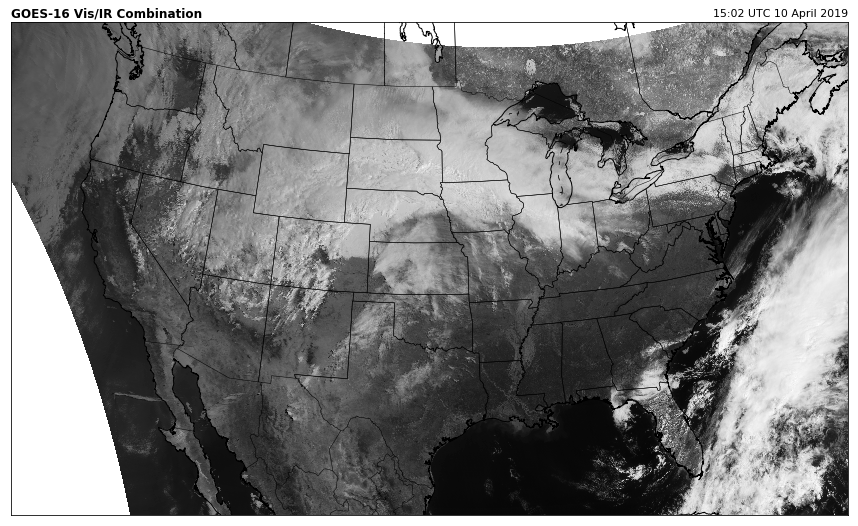

In [11]:
# Overlay night IR with Visible
# Read netcdf file for 'Clean IR' band (Ch13)
#C13_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch13/OR_ABI-L2-CMIPC-M6C13_G16_s20191000016194_e20191000018579_c20191000019022.nc'
C13_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch13/OR_ABI-L2-CMIPC-M6C13_G16_s20191001501176_e20191001503561_c20191001504021.nc'
C13 = Dataset(C13_file, 'r')

# Get date and time - use this info from Ch02 file
#add_seconds = C.variables['t'][0] # Number of seconds since year 2000
#add_seconds=int(add_seconds)
#DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Load the clean IR bands
cleanIR = C13.variables['CMI'][:]

# Apply range limits for clean IR channel
cleanIR=np.clip(cleanIR,90,313)

# Normalize the channel between a range
cleanIR = (cleanIR-90)/(313-90)

# Invert colors to match visible channel 
cleanIR = 1 - cleanIR

# Combine but first resize R array by factor of 4 so it matches cleanIR array in dimension
R = rebin_ndarray(R, new_shape=np.shape(cleanIR), operation='avg') 
Vis_IR = np.maximum(R, cleanIR)

# Basemap
# Satellite height, lon, sweep
sat_h = C13.variables['goes_imager_projection'].perspective_point_height
sat_lon = C13.variables['goes_imager_projection'].longitude_of_projection_origin
sat_sweep = C13.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates
X = C13.variables['x'][:] * sat_h
Y = C13.variables['y'][:] * sat_h

# using the Proj library to generate map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

# Important: Set the "Outer Space" pixels to a point in the Gulf of Alaska
# Without this, re-projections will appear distorted 
lats[R.mask] = 57
lons[R.mask] = -152

# Make a new map object for CONUS Lambert Conformal Conic Projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

# Plot the image
plt.figure(figsize=[15,12])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, Vis_IR, cmap='Greys_r', linewidth=0, latlon=True)
mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 Vis/IR Combination', fontweight='semibold', fontsize=12, loc='left')
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
plt.show()

R shape =  (1500, 2500)
G shape =  (6000, 10000)
G shape =  (1500, 2500)
B shape =  (3000, 5000)
B shape =  (1500, 2500)


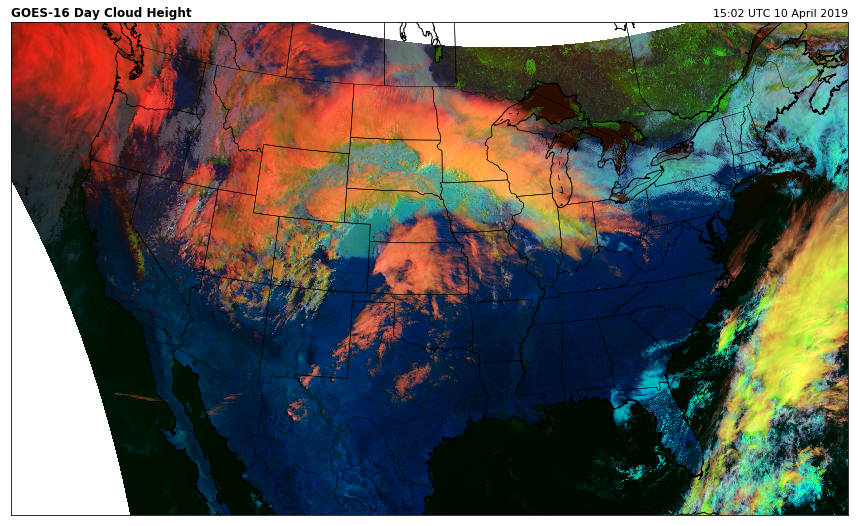

In [23]:
# RGB Color Composite of Cloud Top Height

# This product is used by the National Weather Service in their AWIPS-II system to help forecasters identify 
#    the height of cloud structures seen on the visible imagery. I constructed this composite according to the 
#    recipe found here: http://rammb.cira.colostate.edu/training/visit/quick_guides/Day_Cloud_Phase_Distinction.pdf
# Red colors in the image will correspond to cold ice clouds or cold land, as the red component comes from the clean 
#    IR band, reversed. Thus, regions with cold brightness temperatures will have a large red component. The green 
#    component comes from the visible band, and the blue component comes from the snow/ice band. Both of these bands 
#    are albedoes, as opposed to brightness temperatures. Thus, blue colors will correspond to bare land and liquid 
#    clouds, as snow and ice are not reflective in the snow/ice band. Greens/yellows indicate the presence of snow 
#    cover or mixed-phase clouds, while whiteish-blue colors correspond to primarily warm, liquid clouds.
# This is a day-only product, as both the visible band and snow/ice band will be zero at night. Additionally, this 
#    product may struggle in winter, when snow cover/land may have similar brightness temperatures to ice clouds.

# Read netcdf file
#C02_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch02/OR_ABI-L2-CMIPC-M6C02_G16_s20191000001194_e20191000003567_c20191000004080.nc'
C02_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch02/OR_ABI-L2-CMIPC-M6C02_G16_s20191001501176_e20191001503549_c20191001504065.nc'
C02 = Dataset(C02_file, 'r')
#C05_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch05/OR_ABI-L2-CMIPC-M6C05_G16_s20191000001194_e20191000003568_c20191000004043.nc'
C05_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch05/OR_ABI-L2-CMIPC-M6C05_G16_s20191001501176_e20191001503549_c20191001504028.nc'
C05 = Dataset(C05_file, 'r')
#C13_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch13/OR_ABI-L2-CMIPC-M6C13_G16_s20191000016194_e20191000018579_c20191000019022.nc'
C13_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch13/OR_ABI-L2-CMIPC-M6C13_G16_s20191001501176_e20191001503561_c20191001504021.nc'
C13 = Dataset(C13_file, 'r')

# Get date and time
add_seconds = C02.variables['t'][0] # Number of seconds since year 2000
add_seconds=int(add_seconds)
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Load the RGB arrays
R = C13.variables['CMI'][:] # IR Band 13
print "R shape = ",np.shape(R)
G = C02.variables['CMI'][:] # "Red" Band 2 visible
print "G shape = ",np.shape(G)
G = rebin_ndarray(G, new_shape=np.shape(R), operation='avg') 
print "G shape = ",np.shape(G)
B = C05.variables['CMI'][:] # "Snow/Ice" Band 5
print "B shape = ",np.shape(B)
B = rebin_ndarray(B, new_shape=np.shape(R), operation='avg') 
print "B shape = ",np.shape(B)

# Apply range limits for each channel 
G = np.clip(G, 0, .78) # These are albedo (range from 0 to 1)
B = np.clip(B, .01, .59)
# Normalize between 0 and 1
G = (G-0)/(.78-0)
B = (B-.01)/(0.59--0.01)
# Range limits for IR channel
Rmin=219.65 # Kelvin
Rmax=280.65
R = np.clip(R, Rmin, Rmax)
R = (R-Rmin)/(Rmax-Rmin) # Normalize between the range
R = 1. - R # Make cold brightness temperatures appear red

# The final RGB array :)
RGB = np.dstack([R,G,B])

# Satellite height, lon, sweep
sat_h = C13.variables['goes_imager_projection'].perspective_point_height
sat_lon = C13.variables['goes_imager_projection'].longitude_of_projection_origin
sat_sweep = C13.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates 
X = C13.variables['x'][:] * sat_h
Y = C13.variables['y'][:] * sat_h

# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)
# Important: convert points where R is masked to be a point in the gulf of alaska
lats[R.mask] = 57
lons[R.mask] = -152

# Make a new map object for the CONUS
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:]
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel plots faster

# Plot the image
plt.figure(figsize=[15,12])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)
mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 Day Cloud Height', fontweight='semibold', fontsize=12, loc='left')
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
plt.show()

G shape =  (3000, 5000)
R shape =  (6000, 10000)
R shape =  (3000, 5000)


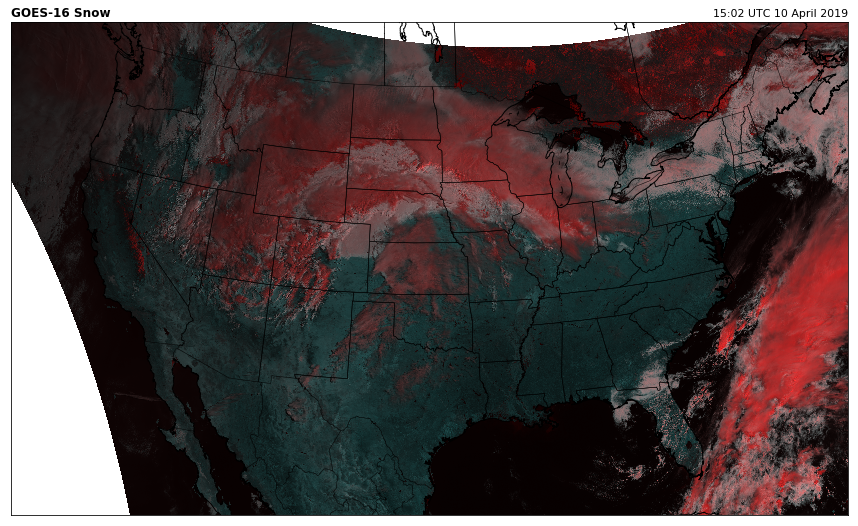

In [24]:
# Snow Cover

# The snow/ice band fact sheet states that a common RGB color composite for identifying snow cover combines 
#    the visible band (red) and the snow/ice band (green and blue). Red shades indicate features that are 
#    more reflective in the 0.64 μm visible band, whereas cyan areas are more reflective in the 1.6 μm (snow/ice) 
#    band. https://www.goes-r.gov/education/docs/ABI-bands-FS/ABI_Band%205_snow-ice_factsheet_FINAL.pdf
# This is a day-only product, as both bands will be zero at night. 
# The land appears blue/green, which is what we expect given that it is more reflective in the snow/ice (1.6 μm) 
#    band. Thus, all regions that contain notable amounts of red color have ice present. However, cirrus clouds 
#    are primarily composed of ice, so they are confused with snow cover. The solution to this is to create a
#    cirrus mask and apply it.  This is done in the next section.

# Read netcdf files
#C02_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch02/OR_ABI-L2-CMIPC-M6C02_G16_s20191000001194_e20191000003567_c20191000004080.nc'
C02_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch02/OR_ABI-L2-CMIPC-M6C02_G16_s20191001501176_e20191001503549_c20191001504065.nc'
C02 = Dataset(C02_file, 'r')
#C05_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch05/OR_ABI-L2-CMIPC-M6C05_G16_s20191000001194_e20191000003568_c20191000004043.nc'
C05_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch05/OR_ABI-L2-CMIPC-M6C05_G16_s20191001501176_e20191001503549_c20191001504028.nc'
C05 = Dataset(C05_file, 'r')

# Get date and time
add_seconds = C02.variables['t'][0] # Number of seconds since year 2000
add_seconds=int(add_seconds)
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Load the RGB arrays
G = C05.variables['CMI'][:]
print "G shape = ",np.shape(G)
B = C05.variables['CMI'][:]
R = C02.variables['CMI'][:]
print "R shape = ",np.shape(R)
R = rebin_ndarray(R, new_shape=np.shape(G), operation='avg') 
print "R shape = ",np.shape(R)

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R=np.clip(R, 0, 1)
G=np.clip(G, 0, 1)
B=np.clip(B, 0, 1)

# Satellite height, lon, sweep
sat_h = C05.variables['goes_imager_projection'].perspective_point_height
sat_lon = C05.variables['goes_imager_projection'].longitude_of_projection_origin
sat_sweep = C05.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates 
X = C05.variables['x'][:] * sat_h
Y = C05.variables['y'][:] * sat_h

# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)
# Important: convert points where R is masked to be a point in the gulf of alaska
lats[R.mask] = 57
lons[R.mask] = -152

# Make a new map object for CONUS Lambert Conformal Conic Projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)


# Create a color tuple for pcolormesh
RGB = np.dstack([R,G,B])
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster, according to stackoverflow. Not sure why.

# Plot the image
plt.figure(figsize=[15,12])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)
mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 Snow', fontweight='semibold', fontsize=12, loc='left')
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
plt.show()

CI shape =  (1500, 2500)


/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1500 but corresponding boolean dimension is 3000
/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1500 but corresponding boolean dimension is 3000


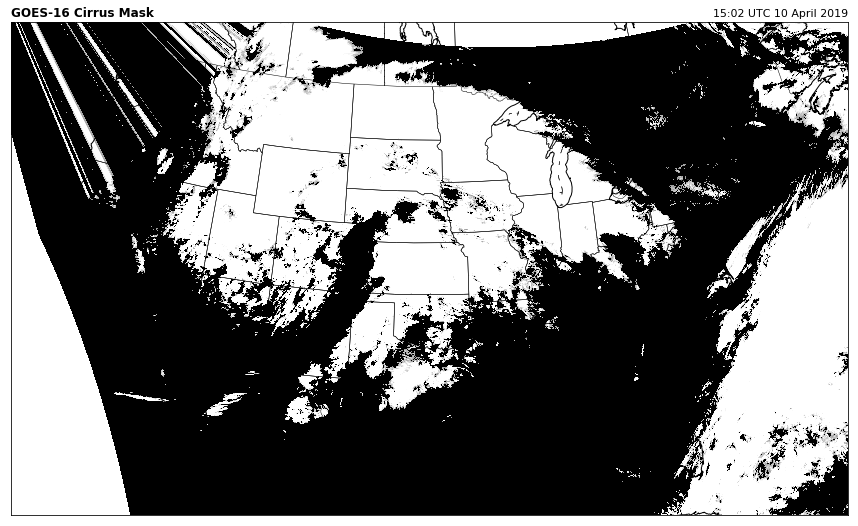

In [25]:
# Make a cirrus mask

# Read netcdf file
#C04_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch04/OR_ABI-L2-CMIPC-M6C04_G16_s20191000001194_e20191000003567_c20191000004031.nc'
C04_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch04/OR_ABI-L2-CMIPC-M6C04_G16_s20191001501176_e20191001503549_c20191001504018.nc'
C04 = Dataset(C04_file, 'r')

# Get date and time
add_seconds = C02.variables['t'][0] # Number of seconds since year 2000
add_seconds=int(add_seconds)
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Load the data
CI = C04.variables['CMI'][:]

print "CI shape = ",np.shape(CI)

# Arbitrary thresholding
CI = np.clip(CI, 0, 0.02) 
CI[CI<0.01] = 0

# Satellite height, lon, sweep
sat_h = C04.variables['goes_imager_projection'].perspective_point_height
sat_lon = C04.variables['goes_imager_projection'].longitude_of_projection_origin
sat_sweep = C04.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates 
X = C04.variables['x'][:] * sat_h
Y = C04.variables['y'][:] * sat_h

# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)
# Important: convert points where R is masked to be a point in the gulf of alaska
lats[R.mask] = 57
lons[R.mask] = -152

# Make a new map object for CONUS Lambert Conformal Conic Projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

# Plot the image
plt.figure(figsize=[15,12])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, CI, cmap='Greys_r', linewidth=0, latlon=True)
mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 Cirrus Mask', fontweight='semibold', fontsize=12, loc='left')
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
plt.show()

G shape =  (3000, 5000)
VIS shape =  (6000, 10000)
VIS shape =  (3000, 5000)
CI shape =  (6000, 10000)
CI shape =  (3000, 5000)


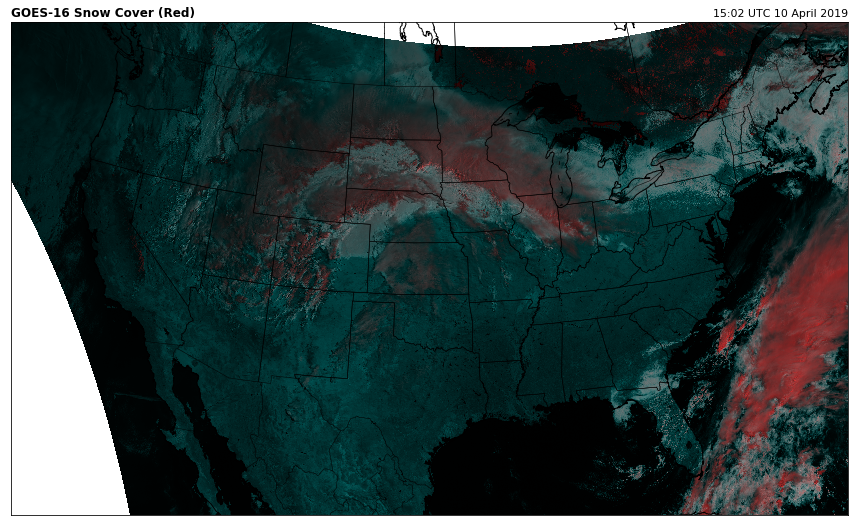

In [26]:
# To apply the cirrus mask, I simply multiply it by ten to scale the values to the values of the Visible 
#    band, and subtract it

# Read netcdf files
#C02_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch02/OR_ABI-L2-CMIPC-M6C02_G16_s20191000001194_e20191000003567_c20191000004080.nc'
CC02_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch02/OR_ABI-L2-CMIPC-M6C02_G16_s20191001501176_e20191001503549_c20191001504065.nc'
C02 = Dataset(C02_file, 'r')
#C04_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch04/OR_ABI-L2-CMIPC-M6C04_G16_s20191000001194_e20191000003567_c20191000004031.nc'
C04_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch04/OR_ABI-L2-CMIPC-M6C04_G16_s20191001501176_e20191001503549_c20191001504018.nc'
C04 = Dataset(C02_file, 'r')
#C05_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch05/OR_ABI-L2-CMIPC-M6C05_G16_s20191000001194_e20191000003568_c20191000004043.nc'
C05_file = '/home/disk/shear2/brodzik/python/goes-r/DATA/L2/CONUS/Ch05/OR_ABI-L2-CMIPC-M6C05_G16_s20191001501176_e20191001503549_c20191001504028.nc'
C05 = Dataset(C05_file, 'r')

# Get date and time
add_seconds = C02.variables['t'][0] # Number of seconds since year 2000
add_seconds=int(add_seconds)
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Load the RGB arrays
G = C05.variables['CMI'][:]
print "G shape = ",np.shape(G)
B = C05.variables['CMI'][:]
VIS = C02.variables['CMI'][:]
print "VIS shape = ",np.shape(VIS)
VIS = rebin_ndarray(VIS, new_shape=np.shape(G), operation='avg') 
print "VIS shape = ",np.shape(VIS)

# Cirrus
CI = C04.variables['CMI'][:]
print "CI shape = ",np.shape(CI)
CI = rebin_ndarray(CI, new_shape=np.shape(G), operation='avg') 
print "CI shape = ",np.shape(CI)
CI = np.clip(CI, 0, 0.02)
CI[CI<0.01] = 0

# Apply cirrus mask
R = VIS - CI*10.

R=np.clip(R, 0, 1)
G=np.clip(G, 0, 1)
B=np.clip(B, 0, 1)

# Satellite height, lon, sweep
sat_h = C05.variables['goes_imager_projection'].perspective_point_height
sat_lon = C05.variables['goes_imager_projection'].longitude_of_projection_origin
sat_sweep = C05.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates 
X = C05.variables['x'][:] * sat_h
Y = C05.variables['y'][:] * sat_h

# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)
# Important: convert points where R is masked to be a point in the gulf of alaska
lats[R.mask] = 57
lons[R.mask] = -152

# Make a new map object for CONUS Lambert Conformal Conic Projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

# Create a color tuple for pcolormesh
RGB = np.dstack([R,G,B])
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster, according to stackoverflow. Not sure why.

# Plot the image
plt.figure(figsize=[15,12])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)
#newmap = mH.pcolormesh(lons, lats, R, cmap='Greys_r', linewidth=0, latlon=True)
mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 Snow Cover (Red)', fontweight='semibold', fontsize=12, loc='left')
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
plt.show()